# Introducción

En el siguiente trabajo vamos a usar los datos etiquetados y no etiquetados para elaborar clasificadores semi y no supervisados.

Primero vamos a retomar lo que hicimos en el práctico combinado de Analisis y Visualización y Curación y vamos a armar dos grafos distintos con dos criterios distintos. Uno de usuarios según los retweets y otro con un criterio elegido por ustedes.

Luego vamos a correr un algoritmo para encontrar comunidades en esos grafos. Las comunidades nos van a permitir dividir el conjunto de entrenamiento en clusters.

Una vez que tenemos las comunidades/clusters definidos, debemos asignar cada uno a una clase. Cada elemento perteneciente a una comunidad asociada a una clase será etiquetado como de esa clase. Luego usaremos esos ejemplos para entrenar nuestro clasificador.

Vamos a hacer esto para los tres tópicos: aborto, cambio climático y feminismo.

In [ ]:
import pandas as pd
# permite que una misma celda imprima varios resultados
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json

from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

!pip install contractions
import contractions
import re
from sklearn import metrics as ms

!pip install cylouvain
import cylouvain
import time
from collections import Counter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


     |████████████████████████████████| 245kB 3.3MB/s 
     |████████████████████████████████| 317kB 17.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=e485e007d8b6477d0deaf69cbd56a734a218503d35f612f63bb784e59957a78c
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 133kB 2.7MB/s 
  Created wheel for cylouvain: filename=cylouvain-0.2.2-cp36-cp36m-linux_x86_64.whl size=400401 sha256=df507d3f7e74193f85b4fb35a109890ad80f5abd1b1198d6845d97909c23d34a
  Stored in directory: /root/.cache/pip/wheels/b9/db/5a/7af4abe124a9394aa70079289b6a2b3f5c8aeb709c0808bcf1
Successfully built cylouvain


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
climate_change = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/climate-change_tweets.csv', engine='python')

### Cobertura

In [ ]:
def get_text(tweet):
    if tweet["tweet.retweeted_status.text"] == tweet["tweet.retweeted_status.text"]:
        return tweet["tweet.retweeted_status.text"]
    else:
        return tweet["tweet.full_text"]

In [ ]:
def get_text2(tweet):
    if tweet["tweet.extended_tweet.full_text"] == tweet["tweet.extended_tweet.full_text"]:  
        return tweet["tweet.extended_tweet.full_text"]
    else:
        return tweet["full_text"]

In [ ]:
climate_change["full_text"] = climate_change.apply(get_text, axis=1)

In [ ]:
climate_change["full_text2"] = climate_change.apply(get_text2, axis=1)

In [ ]:
climate_change["full_text2"] = climate_change["full_text2"].fillna(0)
climate_change['category'] = np.where(climate_change.full_text2 == 0 , 0, 1)
climate_change['full_text2'] = np.where(climate_change['category'] == 0, climate_change['tweet.text'], climate_change['full_text2'])

In [ ]:
print(len(climate_change["tweet.full_text"]))
print(len(climate_change["full_text2"].dropna()))

703486
703486


## Grafo

#### De retweets

In [ ]:
retweets = climate_change.dropna(subset=["tweet.retweeted_status.user.id_str"]) #Subset lo que hace es me elimina la fila si el nan está en la columna que le paso como parámetro
len(retweets["tweet.retweeted_status.user.id_str"])

494161

In [ ]:
full_g = nx.Graph()
vertex_ids = set()


for user1, user2 in zip(retweets["tweet.user.id_str"], retweets["tweet.retweeted_status.user.id_str"]):
    full_g.add_edge(user1, user2)

In [ ]:
n = len(full_g.nodes)
m = len(full_g.edges)
complete = n * (n-1) / 2

print("Nodos: {:.0f}".format(n))
print("Ejes: {:.0f}".format(m))

Nodos: 306950
Ejes: 457813


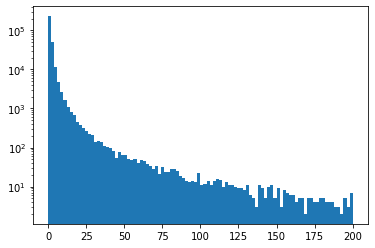

In [ ]:
degrees = np.array([full_g.degree(node) for node in full_g.nodes()])

plt.hist(degrees, range=(0, 200), bins=100);
plt.semilogy();

In [ ]:
def subgraph_strong_nodes(g, n):
    """
    Devuelve subgrafo con nodos de grado mayor a n
    """
    good_nodes = [node for node in g.nodes() if g.degree(node) >= n]
    
    return g.subgraph(good_nodes)

In [ ]:
g = subgraph_strong_nodes(full_g, 5)

print("Nos quedan {:.2f}M nodos (antes eran {:.2f}M)".format(
    len(g.nodes) / 1e6,
    len(full_g.nodes) / 1e6
))
print("Componentes conexas = {}".format(len(list(nx.connected_components(g)))))

Nos quedan 0.02M nodos (antes eran 0.31M)
Componentes conexas = 1930


In [ ]:
components = list(nx.connected_components(g))

print("Componentes conexas = {}".format(len(components)))

print("Componente 0  --> {:<6} usuarios".format(len(components[0])))

resto = [len(components[i]) for i in range(1, len(components))]
print("Restantes     --> {:<6} usuarios".format(sum(resto)))


Componentes conexas = 1930
Componente 0  --> 18337  usuarios
Restantes     --> 2065   usuarios


In [ ]:
g = g.subgraph(components[0])

#### Alternativo

In [ ]:
g2 = # TODO

# Comunidades

Como método para detectar las comunidades vamos a usar el algoritmo de Louvain
https://es.wikipedia.org/wiki/M%C3%A9todo_de_Louvain

Louvain es un método iterativo que busca armar comunidades en función de maximizar la modularidad. A grandes rasgos, arma comunidades tales que hagan que la mayor cantidad de aristas conecten dos nodos que sean de la misma comunidad. El problema es que la solución ideal a esta modularidad es muy costosa computacionalmente. Por lo tanto, Louvain es una heurística iterativa (en cada iteración se acerca un poco más a una solución mejor sin necesariamente llegar a alcanzar una solución ideal). Al ser un método iterativo no es exacto: correrlo varias veces con los mismos parámetros puede dar distintos resultados. El algoritmo termina cuando logra estabilidad, es decir, un valor de modularidad que considera aceptable.

Nosotros vamos a trabajar con un parámetro específico de este algoritmo que es la resolución. La resolución afecta la estabilidad del sistema: a mayor resolución, se necesitan más iteraciones para lograr estabilidad. En particular, lo que a nosotros nos interesa, es que **a mayor resolución, el algoritmo encuentra menos comunidades de mayor tamaño** (se polariza).

Lo que nosotros queremos hacer es encontrar el menor valor de la resolución que nos de como resultado únicamente  dos comunidades polares que tengan más de una cierta cantidad de usuarios (definida en la variable users_threshold)

In [ ]:
# https://pypi.org/project/cylouvain/


# Devuelve todas las particiones según la resolución. Si hay una particion ideal
# (la menor particion que genere 2 o menos comunidades), la devuelve. Sino devuelve -1
def findPartitions(g, user_threshold, resolutions):
    resolutions.sort()
    best_resolution = -1
    found_best = False
    partitions = {}
    for resolution in resolutions:
        print("resolución {:.2f}".format(resolution), end="")

        partition = cylouvain.best_partition(g, resolution=resolution)

        num_partitions = len(set(partition.values()))
        counter = Counter(partition.values())

        # Aca le está diciendo que cuente cuantas son las que tienen usuarios mayores al threshold
        important_partitions = len([_ for x in counter.items() if x[1] > user_threshold])


        if important_partitions <= 2 and not found_best:
            best_resolution = resolution
            found_best = True
            
        print("---> {} particiones ({} con más de {} usuarios)".format(
            num_partitions,
            important_partitions,
            user_threshold,
        ))
        #print("Tiempo: {:.2f} minutos".format((end - begin) / 60))
        partitions[resolution] = partition
    return partitions, best_resolution

In [ ]:
# Ejemplo
partitions, resolution = findPartitions(g, 100,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0, 15.0])

resolución 1.00---> 111 particiones (8 con más de 100 usuarios)
resolución 1.50---> 48 particiones (6 con más de 100 usuarios)
resolución 2.00---> 38 particiones (4 con más de 100 usuarios)
resolución 3.00---> 15 particiones (3 con más de 100 usuarios)
resolución 5.00---> 8 particiones (3 con más de 100 usuarios)
resolución 6.00---> 13 particiones (2 con más de 100 usuarios)
resolución 7.00---> 12 particiones (2 con más de 100 usuarios)
resolución 10.00---> 7 particiones (2 con más de 100 usuarios)
resolución 15.00---> 4 particiones (2 con más de 100 usuarios)


In [ ]:
resolution

6.0

In [ ]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    partition = partitions[resolution]
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")

### Ejercicio 1

Prueben distintos valores de user_threshold y distintas resoluciones evaluando cosas como cuantos (y cuales) nodos del grafo (sean los nodos usuarios u otra cosa) les quedan por fuera de las dos comunidades más grandes (no necesariamente es malo que queden muchos nodos afuera si verdaderamente no tienen una postura clara sobre el tópico); que proporcion tienen esas dos comunidades más grandes: ¿son parejas entre sí o no?; en el caso de que los nodos sean usuarios, además de los usuarios, ¿son parejas la cantidad de tweets que postean esos usuarios? ¿Cuántos tweets hay de cada comunidad?

In [ ]:
partitions, resolution = findPartitions(g, 3000,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0, 15.0, 20.0, 25.0])

resolución 1.00---> 111 particiones (3 con más de 3000 usuarios)
resolución 1.50---> 48 particiones (3 con más de 3000 usuarios)
resolución 2.00---> 38 particiones (3 con más de 3000 usuarios)
resolución 3.00---> 15 particiones (3 con más de 3000 usuarios)
resolución 5.00---> 8 particiones (3 con más de 3000 usuarios)
resolución 6.00---> 13 particiones (2 con más de 3000 usuarios)
resolución 7.00---> 12 particiones (2 con más de 3000 usuarios)
resolución 10.00---> 7 particiones (2 con más de 3000 usuarios)
resolución 15.00---> 4 particiones (2 con más de 3000 usuarios)
resolución 20.00---> 4 particiones (2 con más de 3000 usuarios)
resolución 25.00---> 3 particiones (2 con más de 3000 usuarios)


In [ ]:
resolution

6.0

In [ ]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    partition = partitions[25]
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")

Cantidad de Usuarios y cantidad de Tweets por partición.

Partition 1 y 2 son las comunidades mas grandes.

In [ ]:
comunidad, tweets, comunidades, tweet_comunidad = {}, {}, {}, {}
for i in range(len(set(partition.values()))):
  comunidad[i] = partition_to_ids[i]
  tweet_comunidad[i] = retweets[retweets['tweet.user.id_str'].isin(comunidad[i])]
  comunidades[i] = len(comunidad[i])
  tweets[i] = len(tweet_comunidad[i])

com = pd.DataFrame({'users': comunidades, 'tweets': tweets}) 

In [ ]:
com['tweets por usuario'] = com['tweets'] / com['users'] 
com

,users,tweets,tweets por usuario
0,4470,30903,6.913423
1,50,203,4.060000
2,13817,122083,8.835710


In [ ]:
com.iloc[[0, 2]]['users'].sum() / com['users'].sum()

0.9972732726182036

### Esto es para ver qué hay en los tweets que quedan fuera de las comunidades más grandes

In [ ]:
Counter(partition.values())

Counter({0: 4470, 1: 50, 2: 13817})

In [ ]:
users_out = [key  for (key, value) in partition.items() if value ==2]

In [ ]:
retweets[retweets['tweet.user.id_str'].isin(users_out)]['full_text2'].head(100)

6      RT @GeraldKutney: One molecule of CO2 cannot do much, but gazillions can change a planet’s climate.\n\nOne person cannot do much, but billion…       
7      RT @CraigHill01: So @ScottMorrisonMP supporters are claiming Morrison's critics are to blame for his inaction on climate change, because th…         
18     RT @proustmalone: The fact that these dumbass liberal pundits and their equally dumbass liberal audiences can’t comprehend climate change a…         
24     RT @ScientistsX: https://t.co/S6anKWoFVe                                                                                                             
33     RT @delaneypv15: It's actually racist as hell to imply that Black folks and people of color are not effected by/do not care about climate c…         
37     RT @GretaThunberg: Last month domestic air travel in Sweden was down 11%. \nIn Germany it was down 12%.\nThe climate- and environmental crisi…       
57     While ALL of Australia literally bakes or burns in 

### Ejercicio 2

Armen un script que para cada comunidad muestre datos que permitan evaluar cuan bien se ajusta a la clase a la que la queremos asignar. Algunos ejemplos pueden ser: usuarios con más cantidad de retweets, tweets más retwiteados, tweets de los usuarios con más cantidad de tweets, etc. Tiene que ser algo que de un panorama de qué es esa comunidad pero a su vez sencillo de ver y que convenza a alguien que lo ve desde afuera que usar esas comunidades puede servir.

#### Decidimos ver algunos tweets de los usuarios con mas tweets de cada comunidad. Con lo que podemos concluir que la Comunidad 1 es la que no cree en el cambio climático y la comunidad 2 es la que cree que el cambio climático es una problemática real.

In [ ]:
df_comunidad1 = tweet_comunidad[0] #en contra
df_comunidad2 = tweet_comunidad[2] #a favor

In [ ]:
df_comunidad1.shape, df_comunidad2.shape

((30903, 43), (122083, 43))

Generamos una lista con los 10 usuarios mas tweeteadores de la Comunidad 1 

In [ ]:
list_influencers = df_comunidad1.groupby(by='tweet.user.id_str').count().sort_values(by='query', ascending=False).iloc[:10]

In [ ]:
list_influencers = list_influencers.iloc[:,:0].reset_index()

### Ejemplos de tweets de uno de los usuarios con mas tweets indican que la comunidad 1 es la que cree que el cambio climático **no** es una problemática real

    - Ministers should ensure that schools exist to teach children to read and write, to teach geography, maths and foreign languages — and not fill their heads with a revisionist Left-wing version of history and endless propaganda about 'climate change'
    - Man arrested after 'deliberately starting three blazes' as Australia battles killer bushfires... arson not CO2
    - Climate change is real. The climate is always changing. It always has changed and it always will. CO2 never correlated or caused past climatic changes. It did not cause current changes. It is hubris of man to pretend we cause climate change or weather events

In [ ]:
np.random.seed(33)
retweets[retweets['tweet.user.id_str'] == list_influencers['tweet.user.id_str'][6]].sample(9)

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text,full_text2,category
34675,ObjectId(5dfd66f13337c851a4105f64),streaming,Sat Dec 21 00:27:24 +0000 2019,1208182144222158850,NaN,"RT @OMGTheMess: Turnbull, with a carbon footprint 20 times larger then mine, lectures me on climate change. \n\nDoes nothing himself\n\nLecture…",NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""OMGTheMess"",""name"":""Old Boomer Soldier"",""id"":1388148914,""id_str"":""1388148914"",""indices"":[3,14]}],""symbols"":[]}",205472863,Trakker,tyrelle123,Australia,False,3067,3033,463,NaN,431578,Wed Oct 20 23:38:51 +0000 2010,NaN,NaN,Fri Dec 20 23:27:07 +0000 2019,1.208167e+18,"Turnbull, with a carbon footprint 20 times larger then mine, lectures me on climate change. \n\nDoes nothing himself… https://t.co/pTIQkYz9nT",1.388149e+09,Old Boomer Soldier,OMGTheMess,Here,False,5608.0,3661.0,68.0,NaN,147880.0,Sun Apr 28 23:16:26 +0000 2013,1.388149e+09,NaN,NaN,"{""full_text"":""Turnbull, with a carbon footprint 20 times larger then mine, lectures me on climate change. \n\nDoes nothing himself\n\nLectures us\n\nBut invests in renewables because they get subsidies."",""display_text_range"":[0,182],""entities"":{""hashtags"":[],""urls"":[],""user_mentions"":[],""symbols"":[]}}","Turnbull, with a carbon footprint 20 times larger then mine, lectures me on climate change. \n\nDoes nothing himself… https://t.co/pTIQkYz9nT","Turnbull, with a carbon footprint 20 times larger then mine, lectures me on climate change. \n\nDoes nothing himself… https://t.co/pTIQkYz9nT",1
526419,ObjectId(5e0963e2f8390d4ea28bcad0),streaming,Mon Dec 30 02:41:33 +0000 2019,1211477392255963137,NaN,RT @BobAkerman1: The current bushfire disaster is a direct result of drought and “decades of inaction” about hazardous fuel in the forests.…,NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""BobAkerman1"",""name"":""Bob Akerman"",""id"":293181431,""id_str"":""293181431"",""indices"":[3,15]}],""symbols"":[]}",205472863,Trakker,tyrelle123,Australia,False,3063,3045,462,NaN,434017,Wed Oct 20 23:38:51 +0000 2010,NaN,NaN,Sun Dec 29 21:41:21 +0000 2019,1.211402e+18,The current bushfire disaster is a direct result of drought and “decades of inaction” about hazardous fuel in the f… https://t.co/YDkU3yvQqJ,2.931814e+08,Bob Akerman,BobAkerman1,Bolton Point,False,266.0,271.0,9.0,NaN,11982.0,Wed May 04 22:14:52 +0000 2011,2.931814e+08,NaN,NaN,"{""full_text"":""The current bushfire disaster is a direct result of drought and “decades of inaction” about hazardous fuel in the forests. I will never forgive the “self interested, weak, foolish and deluded” lefties like you Caro, and greens in particular, who stood in the way of reduction. https://t.co/8vHFMSX0Ip"",""display_text_range"":[0,278],""entities"":{""hashtags"":[],""urls"":[{""url"":""https://t.co/8vHFMSX0Ip"",""expanded_url"":""https://twitter.com/janecaro/status/1209

### Comunidad 2

In [ ]:
list_influencers2 = df_comunidad2.groupby(by='tweet.user.id_str').count().sort_values(by='query', ascending=False).iloc[:10]
list_influencers2 = list_influencers2.iloc[:,:1].reset_index()

In [ ]:
list_influencers2

,tweet.user.id_str,_id
0,25081451,340
1,1180555549672460289,253
2,1897328731,247
3,1080209483668901891,237
4,952636350158819328,217
5,59386332,206
6,141009810,199
7,1136477917939027968,198
8,35692915,197
9,1974472332,196


### Ejemplos de tweets de uno de los usuarios con mas tweets indican que la comunidad 2 cree que el cambio climático es una problemática real 

    - New results relying on five decades of satellite observations show extensive changes to glaciers at the Earth's north and south poles, a result of global warming.
    - Climate change is making India’s west coast (including Mumbai) vulnerable to #cyclones : An interview with atmospheric scientist Adam Sobel
    - Infrastructure must be built prudently for transport to become sustainable 

In [ ]:
np.random.seed(40)
retweets[retweets['tweet.user.id_str'] == list_influencers2['tweet.user.id_str'][3]].sample(5)

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text,full_text2,category
424025,ObjectId(5e08cb56f8390d4ea288b10b),streaming,Sun Dec 29 15:50:41 +0000 2019,1211313598875746306,NaN,"RT @insideclimate: In 2019, talks around climate change and agriculture shifted in a major way—with soil taking center stage. Now a new pol…",NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""insideclimate"",""name"":""InsideClimate News"",""id"":14050550,""id_str"":""14050550"",""indices"":[3,17]}],""symbols"":[]}",1080209483668901891,Harrogate EV News ❤🌍♻🔋🚗🚌✈,EvHarrogate,"Harrogate, England",False,466,578,5,NaN,5610,Tue Jan 01 21:09:45 +0000 2019,NaN,NaN,Sun Dec 29 15:10:00 +0000 2019,1.211303e+18,"In 2019, talks around climate change and agriculture shifted in a major way—with soil taking center stage. Now a ne… https://t.co/ksfrjDBiz1",1.405055e+07,InsideClimate News,insideclimate,Everywhere,True,117457.0,2463.0,3490.0,NaN,40049.0,Wed Feb 27 18:41:54 +0000 2008,1.405055e+07,NaN,NaN,"{""full_text"":""In 2019, talks around climate change and agriculture shifted in a major way—with soil taking center stage. Now a new poll commissioned by @UCSUSA shows that soil health could become a political issue. Here’s why that’s important.\n\nhttps://t.co/yRDtAhpz4O"",""display_text_range"":[0,254],""entities"":{""hashtags"":[],""urls"":[{""url"":""https://t.co/yRDtAhpz4O"",""expanded_url"":""http://bit.ly/2QdXK8j"",""display_url"":""bit.ly/2QdXK8j"",""indices"":[231,254]}],""user_mentions"":[{""screen_name"":""UCSUSA"",""name"":""Union of Concerned Scientists"",""id"":18696996,""id_str"":""18696996"",""indices"":[138,145]}],""symbols"":[]}}","In 2019, talks around climate change and agriculture shifted in a major way—with soil taking center stage. Now a ne… https://t.co/ksfrjDBiz1","In 2019, talks around climate change and agriculture shifted in a major way—with soil taking center stage. Now a ne… https://t.co/ksfrjDBiz1",1
663160,ObjectId(5e0a26cff8390d4ea28ffed3),streaming,Mon Dec 30 16:33:13 +0000 2019,1211686691511193600,NaN,RT @SpeakSarahSpeak: I’ll be setting my alarm. \n\nThe comments tho. Pathetic. https://t.co/ARatVCjHGs,NaN,NaN,"{""hashtags"":[],""urls"":[{""url"":""https://t.co/ARatVCjHGs"",""expanded_url"":""https://twitter.com/BBCr4today/status/1211392865869451264"",""display_url"":""twitter.com/BBCr4today/sta…"",""indices"":[77,100]}],""user_mentions"":[{""screen_name"":""SpeakSarahSpeak"",""name"":""Sarah Merrick"",""id"":82729770,""id_str"":""82729770"",""indices"":[3,19]}],""symbols"":[]}",1080209483668901891,Harrogate EV News ❤🌍♻🔋🚗🚌✈,EvHarrogate,"Harrogate, England",False,473,585,5,NaN,5832,Tue Jan 01 21:09:45 +0000 2019,NaN,NaN,Sun Dec 29 22:59:42 +0000 2019,1.211422e+18,I’ll be setting my alarm. \n\nThe comments tho. Pathetic. https://t.co/ARatVCjHGs,8.272977e+07,Sarah Merrick,SpeakSarahSpeak,London,False,3917.0,2892.0,92.0,NaN,12131.0,Thu Oct 15 22:27:41 +0000 2009,8.27

### Ejercicio 3

Hagan una nube de palabras con los tweets de cada comunidad y analicen cuan fácil o difícil es inferir la clase de esa comunidad mirando la nube.

In [ ]:
def preprocesar(text, keep_hashtags=True, remove_numbers=True):
    
    text = contractions.fix(text) 
    
    toks = tokenizer.tokenize(text)
    
    ret = []
    for tok in toks:
                
        if re.match('https?://[A-Za-z0-9./]+',tok):
            continue

        if re.match('[A-Za-z0-9./]+@[A-Za-z0-9./]+',tok):
            continue
            
        if re.match(r'[^\w\s\#,]',tok): #emoji
            continue
            
        if re.match('[^?!.,]*[?.!,]$',tok): #puntuaciones
            continue
          
        if re.match('rt',tok): #puntuaciones
            continue
        
        if re.match('climate',tok): #puntuaciones
            continue
        
        if re.match('climate change',tok): #puntuaciones
            continue
       
        if re.match('change',tok): #puntuaciones
            continue
        
        if tok.isnumeric() and remove_numbers:
            continue
        ret.append(tok)
    return " ".join(ret)

In [ ]:

from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
df_comunidad1["full_text2"] = df_comunidad1["full_text2"].apply(lambda x: preprocesar(x))
df_comunidad2["full_text2"] = df_comunidad2["full_text2"].apply(lambda x: preprocesar(x))

In [ ]:
#desvectorizar
def desvectorizar(lista, dictionary) :
  result = []
  for tweet in lista :
    i = 0
    #print("Lista " +str(tweet))
    for palabra in tweet :
      if palabra > 0 :
        for y in range(palabra):
          result.append(dictionary[i])
      i = i+1
  
  #print("Resultado: "+str(result))
  return result

In [ ]:
def get_feature_names(input_retweets):
    text = input_retweets["full_text2"]

    vectorizer = CountVectorizer(
        binary=False, min_df=0.001, max_df=0.75, ngram_range=(1, 1),
        #stop_words=stopwords.words('spanish')
    )
    X_result = vectorizer.fit_transform([*text])

    return X_result, vectorizer.get_feature_names()

In [ ]:
#Comunidad 1
VEC_BOW_1, diccionario_cc_1 = get_feature_names(df_comunidad1)
bag_of_words_cc_1 = desvectorizar(VEC_BOW_1.toarray(), diccionario_cc_1)
allcomments_1 = " ".join(bag_of_words_cc_1)

#Comunidad 2
VEC_BOW_2, diccionario_cc_2 = get_feature_names(df_comunidad2)
bag_of_words_cc_2 = desvectorizar(VEC_BOW_2.toarray(), diccionario_cc_2)
allcomments_2 = " ".join(bag_of_words_cc_2)

##BOW Comunidad 1 (el cambio climático **no** es un problema real)

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'All Tweets Wordcount')

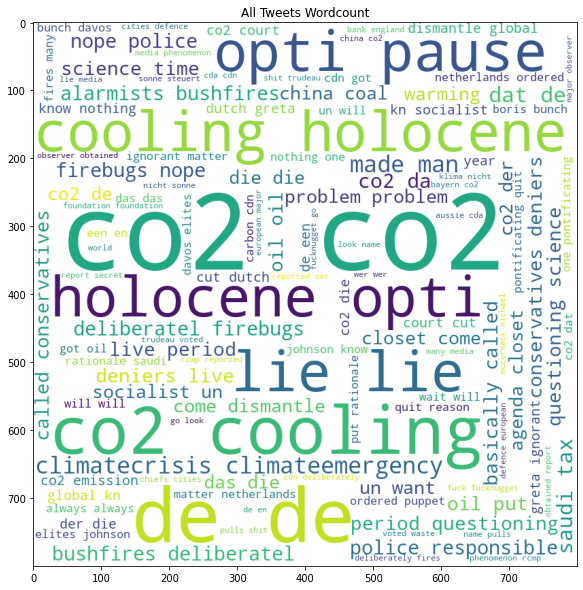

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
wordcloud1 = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 12).generate(allcomments_1)

# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud1)
plt.title("All Tweets Wordcount")
plt.show()

##BOW Comunidad 2 (El cambio climático es un problema real)

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'All Tweets Wordcount')

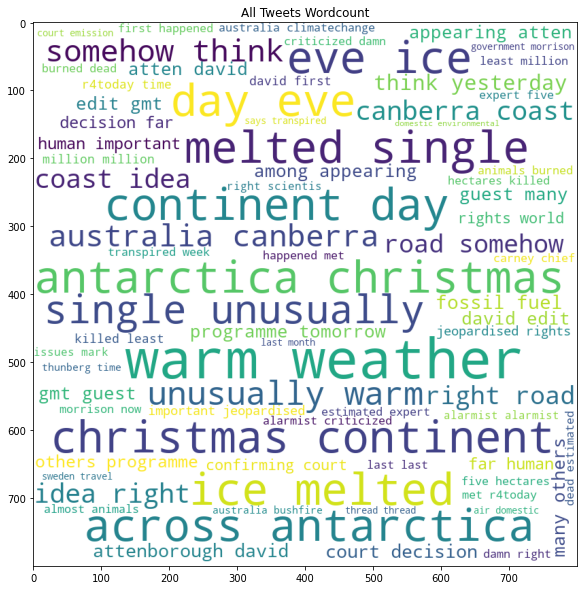

In [ ]:
wordcloud2 = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 12).generate(allcomments_2)

# plot the WordCloud image             
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud2)
plt.title("All Tweets Wordcount")
plt.show()

### Ejercicio 4

Decidan una clase para cada comunidad. Justifiquen su decisión planteando cuán ajustada les parece que es la asignación en función de los ejercicios anteriores

Decidimos que la comunidad 1 está en contra de que el cambio climatico sea un problema real y que la comunidad 2 está a favor de que el cambio climatico es un problema real.

### Ejercicio 5

Hacer los ejercicios anteriores para los tres tópicos y comparar los resultados entre sí: ¿hay tópicos para los cuales las comunidades reflejan mejor o peor la polaridad respecto al posicionamiento? ¿Por qué les parece que esto sucede así?

### Ejercicio 6

Generar un dataset con todos los tweets asociados a cada comunidad, cada uno etiquetado según la comunidad a la que pertenece. Usar esos datasets como entrenamiento de algun clasificador basado en alguno de los tres algoritmos que vieron en el práctico pasado: SVM's, Random Forests o Red Neuronal. Reportar las mismas métricas (Accuracy, F1 micro, macro y average)

In [ ]:
# Generar Dataset con los tweets de comunidad 1 (en contra) y comunidad 2 (a favor), generar una columna nueva STANCE con valores FAVOR y AGAINST
df_comunidad1['Stance'] = 'AGAINST'
df_comunidad2['Stance'] = 'FAVOR'

In [ ]:
df_comunidades_train = pd.concat([df_comunidad1, df_comunidad2])

In [ ]:
df_comunidades_train.groupby(by='Stance').count()['full_text2']

Stance
AGAINST    30903 
FAVOR      122083
Name: full_text2, dtype: int64

In [ ]:
df_comunidades_train = df_comunidades_train.loc[:,['full_text2', 'Stance']]

In [ ]:
np.random.seed(398)
df_comunidades_train.sample(4)

,full_text2,Stance
103346,today there were more than people on the mass strike in moscow so grateful to those who came and helped to orga,FAVOR
348993,most glacial shrinkage in austria occurred before this is a natural process which has been going,AGAINST
250529,yesterday the acting pm said further action was needed on then this today,FAVOR
628966,was als gesunden menschenverstand für sich reklamiert würde #macron als hirntod bezeichnen denn,FAVOR


Renombramos columna full_text2 por Tweet

In [ ]:
df_comunidades_train = df_comunidades_train.rename(columns={'full_text2':'Tweet'})
df_comunidades_train.columns

Index(['Tweet', 'Stance'], dtype='object')

Separamos set de datos en Train y Test

In [ ]:
from sklearn.model_selection import train_test_split

train_cc_com, test_cc_com = train_test_split(
    df_comunidades_train, 
    test_size=0.3, 
    random_state=21
)

# # tomamos solo el 30% de los datos que tenemos. 
# train_cc_com, test_cc_com = train_test_split(
#     train_cc_com, 
#     test_size=0.3, 
#     random_state=21
# )

y_test_com = test_cc_com["Stance"]
y_train_com = train_cc_com["Stance"]

In [ ]:
len(train_cc_com), len(test_cc_com)

(107090, 45896)

### Cargamos Dataset de datos etiquetados (train y test) y los combinamos para tener mas datos de Test. Dado que todos estos datos seran solo para testear. 

In [ ]:
train_etiquetados = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/train.csv', engine='python')
test_etiquetados = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/test.csv', engine='python')

In [ ]:
df_etiquetados = pd.concat([train_etiquetados, test_etiquetados])

In [ ]:
df_etiquetados = df_etiquetados[df_etiquetados["Target"] == "Climate Change is a Real Concern"]

Eliminamos las columnas que no se utilizan y las filas etiquetadas como NONE.

In [ ]:
df_etiquetados.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)

In [ ]:
df_etiquetados = df_etiquetados.drop(df_etiquetados[df_etiquetados['Stance']=='NONE'].index)

In [ ]:
df_etiquetados[df_etiquetados['Stance']=='NONE']

,Tweet,Stance


In [ ]:
df_etiquetados.head(5)

,Tweet,Stance
613,"We cant deny it, its really happening. #SemST",FAVOR
614,RT @cderworiz: Timelines are short. Strategy must be in place by climate change conference in Paris by December. #ableg #SemST,FAVOR
615,SO EXCITING! Meaningful climate change action is on the way! #abpoli #GHG #SemST,FAVOR
616,"Delivering good jobs for Albertans, maintaining a stable economy & meeting climate change strategy. Good goals. #abpoli #GHG #SemST",FAVOR
617,@davidswann says he wants carbon fund to be spent on public transportation and renewable energy. #ejlive #ableg #SemST,FAVOR


### Representamos como Vector el nuevo Dataset generado (etiquetado automaticamente) y el dataset etiquetado dado previamente.


In [ ]:
def dataset_vectorizer(input_train, input_validation, input_test):
    text_train = input_train["Tweet"]
    text_validation = input_validation["Tweet"]
    text_test = input_test["Tweet"]

    vectorizer = CountVectorizer(
        binary=True, min_df=0.004, max_df=0.7, ngram_range=(1, 3)
    )

    X_result = vectorizer.fit_transform([*text_train, *text_validation, *text_test])

    VEC_train = X_result[:len(text_train)]
    VEC_validation = X_result[len(text_train):-len(text_test)]
    VEC_test = X_result[-len(text_test):]
    
    return VEC_train, VEC_validation, VEC_test

In [ ]:
VEC_train_cc, VEC_test_cc, VEC_etiquetados = dataset_vectorizer(train_cc_com, test_cc_com, df_etiquetados)

In [ ]:
y_etiquetados = df_etiquetados['Stance']

In [ ]:
VEC_train_cc.shape, y_train_com.shape, VEC_test_cc.shape, y_test_com.shape, VEC_etiquetados.shape, y_etiquetados.shape

((107090, 941), (107090,), (45896, 941), (45896,), (361, 941), (361,))

*Ya* tenemos los datos necesarios para entrenar nuestro modelo y realizar las predicciones. 

SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC()
model.fit(VEC_train_cc, y_train_com)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred_test =  model.predict(VEC_test_cc)
accuracy_test = accuracy_score(y_test_com, y_pred_test)
f1_test_micro = f1_score(y_test_com, y_pred_test, average="micro", labels=["AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_test_com, y_pred_test, average="macro", labels=["AGAINST", "FAVOR"])
f1_test = f1_score(y_test_com, y_pred_test, average=None, labels=["AGAINST", "FAVOR"])
# f1_test_average = #TODO
f1_test_average = (f1_test[0] + f1_test[1]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de test: 0.93
F1 micro para conjunto de test: 0.93
F1 macro para conjunto de test: 0.88
F1 average para conjunto de test: 0.88


### Probamos predecir el set de datos etiquetado que teniamos previamente. Con el modelo ya entrenado. "model"

In [ ]:
y_pred_test =  model.predict(VEC_etiquetados)
accuracy_test = accuracy_score(y_etiquetados, y_pred_test)
f1_test_micro = f1_score(y_etiquetados, y_pred_test, average="micro", labels=["AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_etiquetados, y_pred_test, average="macro", labels=["AGAINST", "FAVOR"])
f1_test = f1_score(y_etiquetados, y_pred_test, average=None, labels=["AGAINST", "FAVOR"])
# f1_test_average = #TODO
f1_test_average = (f1_test[0] + f1_test[1]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de test: 0.90
F1 micro para conjunto de test: 0.90
F1 macro para conjunto de test: 0.62
F1 average para conjunto de test: 0.62


### Ejercicio 7

Para uno de los tres tópicos, exploren un enfoque mixto supervisado/semi-supervisado. El enfoque mixto puede ser: o bien un Voting Classifier con dos clasificadores que usen el corpus supervisado y uno basado en comunidades (o uno y dos, como prefieran), o un clasificador entrenado con una mitad de ejemplos tomados del corpus de tweets etiquetados y la otra mitad de comunidades. La idea es que definan ustedes alguna manera de usar todos los datos: los etiquetados y los no etiquetados. Luego comparen los resultados obtenidos con las versiones puramente supervisadas o puramente basadas en comunidades.